### Imports

In [4]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randrange
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report

from utils.utility_functions import listdir_nohidden_sorted as lsdir
from vision.vision_utils.video_seq_generator import VideoSeqGenerator

### Paths

In [6]:
MED_FALL = "/home/jovyan/work/MED_Fall"
GROUND_TRUTH_PATH = f"{MED_FALL}/vision/vision_dataset/ground_truth_new"
FRAMES_PATH = f"{MED_FALL}/vision/vision_dataset/extracted_frames"

### Hyperparameters

In [7]:
SEQ_LEN: int = 16
STRIDE: int = 8
BATCH_SIZE: int = 16
INPUT_SHAPE: tuple[int, int, int] = (224, 224, 3)

### Utility Functions

In [8]:
def get_cam(name: str) -> int:
    """
    Extract cam number from each video frame name
    ------

    arguments:
        - name: string containing the frame name. Examle: 'Actor_1_bed_cam_1_0000'

    outputs:
        - cam_number: integer containg the cam number of the provided frame name.
                    Example: if name is 'Actor_1_bed_cam_1_0000', cam_number is: 1.
    """

    start = name.find("cam_")
    ind = start + 4
    cam_number = name[ind]
    return int(cam_number)


def show_frames_series(
    frames_series: np.array, title: str, figsize: tuple[int, int] = (20, 20), nrows=5
):
    """
    plot a series of SEQ_LEN frames with respective labels as titles.
    --------

    arguments:
        - frames_series: np.array containg SEQ_LEN images.
        - title: strcontainging the label of the series of frame. The label is calculated as the mode (most frequent label) of the single frames' labels.
        - fig_size: Optional. Tuple of two integers containing the figure dimensions for the plot. Default is (20, 20).

    """
    rows = nrows

    fig = plt.figure(figsize=figsize)
    for n, image in enumerate(frames_series):
        a = fig.add_subplot(rows, int(len(frames_series) / float(rows)), n + 1)

        plt.imshow(image)
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

## Load Dataset

In [9]:
# Load all csv files (one per actor). Each file contains frames names and respective labels.
dfs = []
for file in lsdir(GROUND_TRUTH_PATH):
    df = pd.read_csv(file)
    dfs.append(df)
# concatenate all csv files in one pandas DF
dataset = pd.concat(dfs, ignore_index=True, axis=0)
dataset = dataset.iloc[:, 2:]
dataset

,micro_labels,macro_labels,ar_labels,frame_name
0,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0000
1,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0001
2,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0002
3,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0003
4,lie_still,lying_down,actor_repositioning,actor_1_bed_cam_1_0004
...,...,...,...,...
1182295,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4615
1182296,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4616
1182297,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4617
1182298,stand_up_from_floor,adl,actor_repositioning,actor_4_chair_full_ph_cam_7_4618


In [10]:
# Select only "on_air" frames (where actors are performing sequences)
dataset_onair = dataset.loc[dataset["ar_labels"] == "on_air"].copy()
dataset_onair

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210
...,...,...,...,...
1182213,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4533
1182214,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4534
1182215,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4535
1182216,crouched_still,falling,on_air,actor_4_chair_full_ph_cam_7_4536


In [11]:
# check on_air dataset samples per class
dataset_onair["macro_labels"].value_counts()

adl           269836
falling        88312
lying_down     27958
Name: macro_labels, dtype: int64

In [12]:
# instantiate and fit a OneHotEncoder for the macro classes (adl, fall, lie_down)
le = LabelBinarizer()
le.fit(dataset_onair["macro_labels"])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'adl': array([1, 0, 0]),
 'falling': array([0, 1, 0]),
 'lying_down': array([0, 0, 1])}

## Use actor 4 as test set

In [13]:
actor_4 = dataset_onair.loc[dataset_onair["frame_name"].str.contains("actor_4")].copy()

In [14]:
actor_123 = dataset_onair.drop(actor_4.index)
actor_123

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210
...,...,...,...,...
1013767,lie_down_on_the_floor,lying_down,on_air,actor_3_walk_stick_full_ph_cam_7_5767
1013768,lie_down_on_the_floor,lying_down,on_air,actor_3_walk_stick_full_ph_cam_7_5768
1013769,lie_down_on_the_floor,lying_down,on_air,actor_3_walk_stick_full_ph_cam_7_5769
1013770,lie_down_on_the_floor,lying_down,on_air,actor_3_walk_stick_full_ph_cam_7_5770


In [15]:
train_set = actor_123

In [16]:
train_set["macro_labels"].value_counts()

adl           244132
falling        75320
lying_down     27286
Name: macro_labels, dtype: int64

In [17]:
test_set = actor_4
test_set["macro_labels"].value_counts()

adl           25704
falling       12992
lying_down      672
Name: macro_labels, dtype: int64

## Balance dataset

In [18]:
# dataset_balanced = dataset_onair.copy()  # make a copy of on_air dataset

counts = train_set["macro_labels"].value_counts()  # count samples per class
minority_class_samples = counts[-1]  # store minority class samples

# select adl samples
adl_samples = train_set.loc[dataset["macro_labels"] == "adl"]

# select fall samples
fall_samples = train_set.loc[dataset["macro_labels"] == "falling"]

## subsample

# count exceeding adl samples wrt minority_class_samples
adl_todrop_ind = len(adl_samples) - minority_class_samples
# count exceeding fall samples wrt minority_class_samples
fall_todrop_ind = len(fall_samples) - minority_class_samples

# select indices to drop from adl subset
adl_samples_to_drop = adl_samples.iloc[-adl_todrop_ind:]

# select indices to drop from fall subset
fall_samples_to_drop = fall_samples.iloc[-fall_todrop_ind:]

# actually drop exceeding adl samples
train_set.drop(adl_samples_to_drop.index, axis=0, inplace=True)

# actually drop exceeding fall samples
train_set.drop(fall_samples_to_drop.index, axis=0, inplace=True)

# count samples per class of the balanced dataset
train_set["macro_labels"].value_counts()

adl           27286
falling       27286
lying_down    27286
Name: macro_labels, dtype: int64

In [19]:
train_set.sort_index(inplace=True)

In [20]:
adl_samples = train_set.loc[dataset["macro_labels"] == "adl"]
fall_samples = train_set.loc[dataset["macro_labels"] == "falling"]
lie_down_samples = train_set.loc[dataset["macro_labels"] == "lying_down"]

split_ratio = 0.8
split_adl = int(len(adl_samples) * split_ratio)
split_fall = int(len(fall_samples) * split_ratio)
split_lie_down = int(len(lie_down_samples) * split_ratio)

val_adl = adl_samples.iloc[split_adl:].copy()
val_fall = fall_samples.iloc[split_fall:].copy()
val_lie_down = lie_down_samples.iloc[split_lie_down:].copy()

val_set = pd.concat([val_adl, val_fall, val_lie_down], axis=0)
val_set

,micro_labels,macro_labels,ar_labels,frame_name
113022,rolling_bed,adl,on_air,actor_1_bed_rolling_ph2_cam_2_0882
113023,rolling_bed,adl,on_air,actor_1_bed_rolling_ph2_cam_2_0883
113024,rolling_bed,adl,on_air,actor_1_bed_rolling_ph2_cam_2_0884
113025,rolling_bed,adl,on_air,actor_1_bed_rolling_ph2_cam_2_0885
113026,rolling_bed,adl,on_air,actor_1_bed_rolling_ph2_cam_2_0886
...,...,...,...,...
1013767,lie_down_on_the_floor,lying_down,on_air,actor_3_walk_stick_full_ph_cam_7_5767
1013768,lie_down_on_the_floor,lying_down,on_air,actor_3_walk_stick_full_ph_cam_7_5768
1013769,lie_down_on_the_floor,lying_down,on_air,actor_3_walk_stick_full_ph_cam_7_5769
1013770,lie_down_on_the_floor,lying_down,on_air,actor_3_walk_stick_full_ph_cam_7_5770


In [21]:
train_set.drop(val_set.index, inplace=True)
train_set

,micro_labels,macro_labels,ar_labels,frame_name
206,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0206
207,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0207
208,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0208
209,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0209
210,sit_up_from_lying,adl,on_air,actor_1_bed_cam_1_0210
...,...,...,...,...
635802,lie_down_on_the_floor,lying_down,on_air,actor_2_chair_ph_cam_4_1302
635803,lie_down_on_the_floor,lying_down,on_air,actor_2_chair_ph_cam_4_1303
635804,lie_down_on_the_floor,lying_down,on_air,actor_2_chair_ph_cam_4_1304
635805,lie_down_on_the_floor,lying_down,on_air,actor_2_chair_ph_cam_4_1305


In [22]:
train_set["macro_labels"].value_counts()

adl           21828
falling       21828
lying_down    21828
Name: macro_labels, dtype: int64

## Instantiate train and val generators
### VideoSeqGenerator works as follows:
- takes a dataframe containing the frame names and the corresponding labels as input
- splits the dataframe in time series of length SEQ_LEN
- for each series: 
    - loads a batch made of BATCH_SIZE * SEQ_LEN frames into a tensor called "X"
    - for each window (time-series) of the batch caluculates the mode of the frames, applies OneHotEncoding and stores the encoded windows' labels in a tensor called "y".
    - returns X,y. 
      X has shape (BATCH_SIZE, SEQ_LEN, IMAGE_SIZE), for example (32, 20, 224, 224, 3)
      y has shape (BATCH_SIZE, 3),  where 3 derives from the one hot encoding of the 3 classes (adl, fall, lie_down)

In [23]:
# instantiating train generator. For this test there will be only one generator which takes the whole dataset as input
train_gen = VideoSeqGenerator(
    frames_path=FRAMES_PATH,
    df=train_set,
    seq_len=SEQ_LEN,
    stride=STRIDE,
    batch_size=BATCH_SIZE,
    label_encoder=le,
    input_shape=INPUT_SHAPE,
)

(224, 224, 3)
<class 'tuple'>


In [24]:
val_gen = VideoSeqGenerator(
    frames_path=FRAMES_PATH,
    df=val_set,
    seq_len=SEQ_LEN,
    batch_size=BATCH_SIZE,
    stride=STRIDE,
    label_encoder=le,
    input_shape=INPUT_SHAPE,
)

(224, 224, 3)
<class 'tuple'>


In [25]:
train_gen.df["macro_labels"].value_counts()

adl           21828
falling       21828
lying_down    21828
Name: macro_labels, dtype: int64

### Plot a frames series from first batch
    The first two images are black, in fact they are padding frames, because those two frames in the dataframe were part of another sequence. In other words, such frames had a different camera number with respect to the others.

batch_X.shape: (16, 16, 224, 224, 3) batch_y.shape: (16, 3)


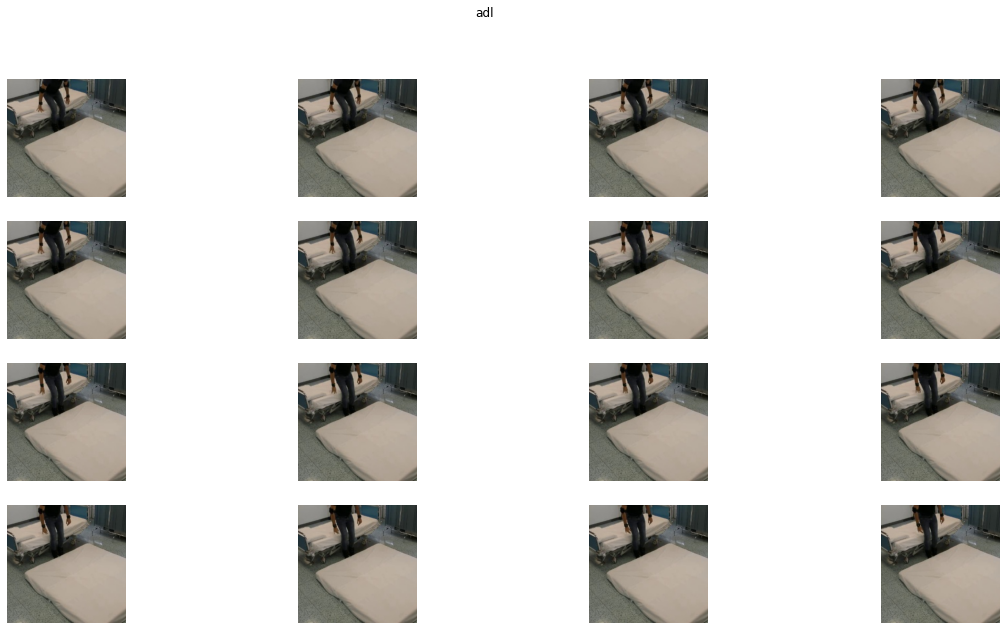

In [26]:
# get first batch from train generator

batch_number = randrange(0, 100)

batch_X, batch_y = train_gen.__getitem__(batch_number)
print("batch_X.shape:", batch_X.shape, "batch_y.shape:", batch_y.shape)

window_number = randrange(0, 3)

frames = batch_X[window_number]
title = np.expand_dims(batch_y[window_number], axis=0)
title = le.inverse_transform(title)[0]
title

show_frames_series(frames, title, figsize=(20, 10), nrows=4)

### Metrics

In [27]:
# we keep track of the recall (sensitivity, or number of correctly predicted true positive).
# This metric is especially important for the fall class, where we want to have maximum recall to be sure we don't miss any fall event.
metrics = [
    tf.keras.metrics.CategoricalAccuracy(),
    tf.keras.metrics.Recall(class_id=0, name="adl"),
    tf.keras.metrics.Recall(class_id=1, name="fall"),
    tf.keras.metrics.Recall(class_id=2, name="lying_down"),
]

2022-09-10 12:59:57.317692: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-10 12:59:57.317758: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 192c59ef2423
2022-09-10 12:59:57.317777: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 192c59ef2423
2022-09-10 12:59:57.317990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.47.3
2022-09-10 12:59:57.318032: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-09-10 12:59:57.318049: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.129.6 does not match DSO version 510.47.3 -- cannot find working devices in this configuration
2022-09-10 12:59:57.318569: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI

### Callbacks

In [28]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{MED_FALL}/vision/models/LRCN.h5"
)

callbacks = [model_checkpoint]

## Define LRCN model

In [30]:
convnet = tf.keras.models.load_model(
    f"{MED_FALL}/vision/models/vgg_feature_extractor.h5"
)

In [31]:
LRCN = Sequential()
LRCN.add(layers.Input(shape=(SEQ_LEN,) + INPUT_SHAPE))
LRCN.add(layers.TimeDistributed(convnet))
LRCN.add(layers.LSTM(units=256, return_sequences=True))
LRCN.add(layers.LSTM(units=128, return_sequences=False))
LRCN.add(layers.Dense(units=3, activation="softmax"))
LRCN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 512)           14714688  
_________________________________________________________________
lstm (LSTM)                  (None, 16, 256)           787456    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 15,699,651
Trainable params: 984,963
Non-trainable params: 14,714,688
_________________________________________________________________


### Compile Model

In [32]:
LRCN.compile(optimizer="adam", loss="categorical_crossentropy", metrics=metrics)

### Fit Model

In [ ]:
history = LRCN.fit(train_gen, validation_data=val_gen, epochs=20, shuffle=True, callbacks=callbacks)

2022-09-10 13:02:11.105536: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-10 13:02:13.203382: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3288334336 exceeds 10% of free system memory.
2022-09-10 13:02:13.504054: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3288334336 exceeds 10% of free system memory.
2022-09-10 13:02:14.384975: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 822083584 exceeds 10% of free system memory.
2022-09-10 13:02:14.658746: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1644167168 exceeds 10% of free system memory.
2022-09-10 13:02:14.962263: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1644167168 exceeds 10% of free system memory.


255/255 [==============================] - 2559s 10s/step - loss: 1.0450 - categorical_accuracy: 0.4576 - adl: 0.4650 - fall: 0.2411 - lying_down: 0.2138 - val_loss: 1.2784 - val_categorical_accuracy: 0.4048 - val_adl: 0.2803 - val_fall: 0.0175 - val_lying_down: 0.3406
Epoch 2/20
255/255 [==============================] - 2581s 10s/step - loss: 0.9818 - categorical_accuracy: 0.5125 - adl: 0.4547 - fall: 0.2693 - lying_down: 0.2473 - val_loss: 1.1148 - val_categorical_accuracy: 0.4286 - val_adl: 0.0607 - val_fall: 0.5614 - val_lying_down: 0.1250
Epoch 3/20
255/255 [==============================] - 2579s 10s/step - loss: 0.9587 - categorical_accuracy: 0.5292 - adl: 0.4075 - fall: 0.3583 - lying_down: 0.2393 - val_loss: 1.2196 - val_categorical_accuracy: 0.4415 - val_adl: 0.1763 - val_fall: 0.0848 - val_lying_down: 0.4594
Epoch 4/20
144/255 [===============>..............] - ETA: 14:58 - loss: 0.9374 - categorical_accuracy: 0.5312 - adl: 0.5076 - fall: 0.4313 - lying_down: 0.2476

In [ ]:
model.save(f"{MED_FALL}/vision/models/LRCN_actors123.h5")

In [ ]:
# plot the accuracies
plt.figure()
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
# plot the losses
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.grid()
plt.show()

In [ ]:
y_logits = model.predict(val_gen)
print(y_logits.shape)

In [ ]:
y_preds_encoded = []
for logit in y_logits:
    one_hot_labl = [0, 0, 0]
    argmax = np.argmax(logit, axis=0)
    one_hot_labl[argmax] = 1
    y_preds_encoded.append(one_hot_labl)

y_preds_encoded

In [ ]:
len(val_gen.windows_labels)

In [ ]:
y_true = val_gen.windows_labels
pd.Series(y_true).value_counts()

In [ ]:
y_true_encoded = le.transform(y_true)

In [ ]:
print(
    classification_report(
        y_true=y_true_encoded,
        y_pred=y_preds_encoded,
        target_names=["adl", "fall", "lie_down"],
    ),
)

In [ ]:
model.evaluate(train_gen)

In [ ]:
model.evaluate(val_gen)